In [1]:
#from mamba_ssm import Mamba

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bm3d
from rich import inspect

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
from torchvision import datasets, transforms
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import random_split
import torch.nn.functional as F
import random as rd

import os

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [4]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (gpu_avail): 
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

In [5]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # gpu vars
    torch.backends.cudnn.deterministic = True  #needed
    torch.backends.cudnn.benchmark = False

In [6]:
## https://www.geeksforgeeks.org/implement-convolutional-autoencoder-in-pytorch-with-cuda/
## https://github.com/DevelopersHong/unet-aspp-segmentation/blob/master/unet/nested_unet_aspp.py

In [7]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest train loss: {self.best_valid_loss}")
            print(f"Saving best model for epoch: {epoch+1}\n")
            torch.save( model, 'outputs/best_model.pth')

In [8]:
def save_model(epochs, model, optimizer):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save( model, 'outputs/final_model.pth')

In [9]:
EPS = 1e-8
def PSNR(input, target):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)

def MSE(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])

# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (gpu_avail): 
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU
    

In [10]:
PATH = "~/unett/flowers/flowers-102/"
PATH_test = "~/unett/flowers/BSD300/"

In [11]:
data_dir = PATH 
batch_size=10
Num_of_It = 100
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor()
                               ])
dataset = datasets.ImageFolder(data_dir, transform=transform)
lengths = [int(len(dataset)*0.8), int(len(dataset)*0.2)]

train_dataset, val_dataset = random_split(dataset, lengths)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
test_dataset = datasets.ImageFolder(PATH_test , transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406]) #np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225]) #np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<AxesSubplot:>

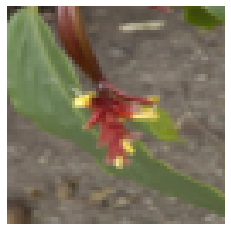

In [14]:
# Visualizing an image from the dataset
images, _ = next(iter(val_dataloader))
imshow(images[1], normalize=False)

<AxesSubplot:>

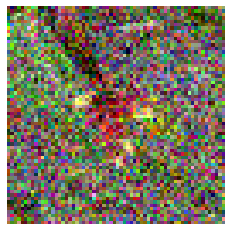

In [15]:
noisy_images = (images + torch.normal(0,0.2, images.shape)).clip(0,1)
imshow(noisy_images[1], normalize=False)

In [16]:
#!pip install piqa

In [17]:
from piqa import SSIM

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

criterion = SSIMLoss().cuda()

In [18]:
### denoising with autoencoder
#https://github.com/SaoYan/DnCNN-PyTorch

In [19]:
loss_module = nn.SmoothL1Loss() #nn.L1Loss() # MSELoss(size_average=False)
#loss_module= criterion

In [20]:
def eval_model(model, dataloader, noise_type, noise_parameter):
    model.eval()
    psnr = []
    mse = []
    seed_value = 1234 #4444 #3333 #2222 #1111 #1234
    rd.seed(seed_value) # set random seed
    np.random.seed(seed_value) # set numpy seed
    torch.manual_seed(seed_value) # set pytorch seed CPU
    if (gpu_avail): 
        torch.cuda.manual_seed(seed_value) # set pytorch seed GPU
    with torch.no_grad():
        for images, _ in dataloader:
            #noisy_images = torch.clone(images)
            if (noise_type == "normal"):
                noisy_images = (images + torch.normal(0,noise_parameter,images.shape)).clip(0,1)
            elif (noise_type == "bernoulli"):
                a = noise_parameter*torch.ones(images.shape)
                noisy_images = images*torch.bernoulli(a)
            elif (noise_type == "poisson"):
                a = noise_parameter*torch.ones(images.shape)
                p = torch.poisson(a)
                p_norm = p/p.max()
                noisy_images = (images + p_norm).clip(0,1)
            images = images.to(device)

            
            
            noisy_images = noisy_images.to(device)
            preds = model(noisy_images)
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))
            mse.extend(MSE(images.cpu().detach(), preds.cpu().detach()))
        print(f"Peak Signal to Noise Ratio:   Mean: {np.array(psnr).mean()} || Std: {np.array(psnr).std()}")
        print(f"Mean Squared Error:   Mean: {np.array(mse).mean()} || Std: {np.array(mse).std()}")
        return np.array(psnr).mean(), np.array(mse).mean()

In [21]:
def train_model(model, noise_type, noise_parameter, optimizer, train_dataloader, val_dataloader, loss_module, num_epochs=3):
    model.train()
    epoch_num = []
    mse_train = []
    mse_val = []
    psnr_train = []
    psnr_val = []
    losses = []
    mse = 0.0
    psnr = 0.0
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        for images, _ in train_dataloader:
            targets = torch.clone(images)
            

                
            if (noise_type == "normal"):
                images = (images + torch.normal(0,noise_parameter,images.shape)).clip(0,1)
            elif (noise_type == "bernoulli"):
                a = noise_parameter*torch.ones(images.shape)
                images = images*torch.bernoulli(a)
            elif (noise_type == "poisson"):
                a = noise_parameter*torch.ones(images.shape)
                p = torch.poisson(a)
                p_norm = p/p.max()
                images = (images + p_norm).clip(0,1)
            
           
            
            images = images.to(device)
            targets = targets.to(device)
            preds = model(images)
            
            loss = loss_module(preds, targets)
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
 

   
        if (epoch%2 == 0):
            print(f"********EPOCH {epoch+1}:********")
            epoch_num.append(epoch+1)
            print("Valid set:")
            psnr, mse = eval_model(model, val_dataloader, noise_type, noise_parameter)
            psnr_train.append(psnr)
            mse_train.append(mse)

            # save the best model till now if we have the least loss in the current epoch
            save_best_model(mse, epoch, model, optimizer )
            

        print(f"Epoch {epoch+1}/{num_epochs} - Validation loss: {mse}")
    
    print("Final train set:")
    psnr, mse = eval_model(model, val_dataloader, noise_type, noise_parameter)
    
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(mse, epoch, model, optimizer )
    # save the trained model weights for a final time
    save_model(epoch, model, optimizer)
    return epoch_num, psnr_train, mse_train

In [22]:
##https://www.kaggle.com/code/faizalkarim/image-colorization-auto-encoders-pytorch

In [23]:
class Encoderis(nn.Module):
    def __init__(self, do_bn = True):
        super(Encoderis, self).__init__()
        self.block1 = self.inner_block(3, 32)
        self.block2 = self.inner_block(32, 64)
        self.block3 = self.inner_block(64, 128)
        self.block4 = self.inner_block(128, 256)
        self.block5 = self.inner_block(256, 384)

        
    def inner_block(self, in_c, out_c, maxpool = 2):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size = 3, stride = 1, padding = 1, padding_mode="reflect", bias = False),
            nn.BatchNorm2d(out_c,eps=1e-5, momentum=0.01, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(out_c, out_c, kernel_size = 3, stride = 1, padding = 1, padding_mode="reflect", bias = False),
            nn.BatchNorm2d(out_c,eps=1e-5, momentum=0.01, affine=True),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
    def forward(self, x):
        # 3, 150, 150
        h1 = self.block1(x) # 32, 75, 75
        
        h2 = self.block2(h1) # 64, 37, 37
        
        h3 = self.block3(h2) # 128, 18, 18
        
        h4 = self.block4(h3) # 256, 9, 9
        
        h5 = self.block5(h4) # 384, 4, 4
        
        
        return [h1, h2, h3, h4, h5]

In [24]:
class Decoderis(nn.Module):
    
    def __init__(self, do_bn = True):
        super(Decoderis, self).__init__()
        self.inner1 = self.inner_block(384, 256, 2, 0)
        self.inner2 = self.inner_block(256, 128, 2, 0)
        self.inner3 = self.inner_block(128, 64, 2, 0)
        self.inner4 = self.inner_block(64, 32, 2, 0)
        self.inner5 = self.inner_block(32, 3, 4, 1, out = True)
        
        self.cb1 = self.conv_block(512, 256)
        self.cb2 = self.conv_block(256, 128)
        self.cb3 = self.conv_block(128, 64)
        self.cb4 = self.conv_block(64, 32)
        self.linear1 = nn.Linear(4, 4, bias=False)
        self.linear2 = nn.Linear(8, 8, bias=False)
        self.linear3 = nn.Linear(16, 16, bias=False)
        self.linear4 = nn.Linear(32, 32, bias=False)
        
        
    def inner_block(self, in_c, out_c, kernel_size, padding, out = False,):
        return  nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size = kernel_size, stride = 2, padding = padding, bias = False),
            nn.BatchNorm2d(out_c,eps=1e-5, momentum=0.01, affine=True),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(out_c, out_c, kernel_size = 3, stride = 1, padding = 1, padding_mode="reflect"),
            nn.LeakyReLU() if not out else nn.Hardsigmoid(),
            nn.Dropout(0.2) if not out else nn.Identity(),
        )
    
    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
            
    def forward(self, h):
        
        # 384, 5, 5
        x = h[-1]
        x = self.inner1(x)         # 256, 9, 9 

        
        x = torch.concat([x, h[-2]], dim = 1)
        inputs = F.interpolate(x, size=[4, 4],   mode='bilinear', align_corners=True)
        outputs = self.linear1(inputs)
        x = x+ F.interpolate(outputs, size=[x.shape[2], x.shape[3]],   mode='bilinear', align_corners=True) 
        #
        x = self.cb1(x)
        x = self.inner2(x)         # 128, 16px, 16px
        
        x = torch.concat([x, h[-3]], dim = 1)
        inputs = F.interpolate(x, size=[8, 8],   mode='bilinear', align_corners=True)
        outputs = self.linear2(inputs)
        x = x+ F.interpolate(outputs, size=[x.shape[2], x.shape[3]],   mode='bilinear', align_corners=True) 
        #
        x = self.cb2(x)
        
        
        x = self.inner3(x)         # 64, 32px, 32px

        
        x = torch.concat([x, h[-4]], dim = 1)
        inputs = F.interpolate(x, size=[16, 16],   mode='bilinear', align_corners=True)
        outputs = self.linear3(inputs)
        x = x+ F.interpolate(outputs, size=[x.shape[2], x.shape[3]],   mode='bilinear', align_corners=True) 
        x = self.cb3(x)
        x = self.inner4(x)         # 32, 64px, 64px

        
        
        x = torch.concat([x, h[-5]], dim = 1)
        inputs = F.interpolate(x, size=[32, 32],   mode='bilinear', align_corners=True)
        outputs = self.linear4(inputs)
        x = x+ F.interpolate(outputs, size=[x.shape[2], x.shape[3]],   mode='bilinear', align_corners=True) 
        x = self.cb4(x)
        x = self.inner5(x)         # 3, 128px, 128px 


    
        return x

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.encoder = Encoderis(do_bn = True)
        self.decoder = Decoderis(do_bn = True)
        
        
    def forward(self, x):
        
        h = self.encoder(x)   
        h = self.decoder(h)
        return h
   

In [26]:
#import math
modelis = Net()
modelis.to(device)
print()

In [27]:
normal_optimizer_mse = optim.AdamW(modelis.parameters(), lr=1e-3, weight_decay=1e-4, eps=1e-8)
save_best_model = SaveBestModel()

In [28]:
%%time
epoch_num2, psnr_train2, mse_train2=train_model(modelis, "normal", 0.20, normal_optimizer_mse, train_dataloader, val_dataloader, loss_module,  num_epochs=5)

********EPOCH 1:********
Valid set:
Peak Signal to Noise Ratio:   Mean: 21.10064697265625 || Std: 1.539376139640808
Mean Squared Error:   Mean: 0.008308433927595615 || Std: 0.003528638742864132

Best train loss: 0.008308433927595615
Saving best model for epoch: 1

Epoch 1/100 - Validation loss: 0.008308433927595615
Epoch 2/100 - Validation loss: 0.008308433927595615
********EPOCH 3:********
Valid set:
Peak Signal to Noise Ratio:   Mean: 24.045503616333008 || Std: 1.4805678129196167
Mean Squared Error:   Mean: 0.004184604622423649 || Std: 0.0015847189351916313

Best train loss: 0.004184604622423649
Saving best model for epoch: 3

Epoch 3/100 - Validation loss: 0.004184604622423649
Epoch 4/100 - Validation loss: 0.004184604622423649
********EPOCH 5:********
Valid set:
Peak Signal to Noise Ratio:   Mean: 24.372568130493164 || Std: 1.4563624858856201
Mean Squared Error:   Mean: 0.003867426887154579 || Std: 0.0013662800192832947

Best train loss: 0.003867426887154579
Saving best model for e

KeyboardInterrupt: 

In [33]:
modelis = Net()

normal_optimizer_mse = optim.AdamW(modelis.parameters(), lr=0.5e-3, weight_decay=1e-4, eps=1e-8)
modelis = torch.load('./outputs/best_model.pth', map_location=device)
torch.save( modelis, 'outputs/best_model_denoise.pth')
modelis = modelis.to(device)

print(f"Best model was loaded\n")
import os
os.remove('./outputs/best_model.pth')
print("Old model removed successfully")


FileNotFoundError: [Errno 2] No such file or directory: './outputs/best_model.pth'

In [34]:
modelis = torch.load('./outputs/best_model_denoise.pth', map_location=device)

Validation set:
Peak Signal to Noise Ratio:   Mean: 25.88547706604004 || Std: 1.6136679649353027
Mean Squared Error:   Mean: 0.002750969026237726 || Std: 0.0009536827565170825


<Figure size 1500x1000 with 0 Axes>

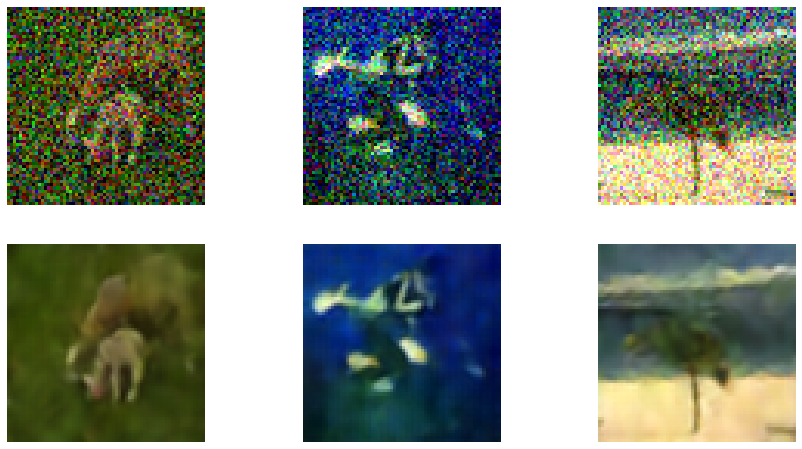

mean MSE=  0.002750969
mean PSNR=  25.885477
CPU times: user 4.54 s, sys: 169 ms, total: 4.71 s
Wall time: 1.16 s


In [35]:
%%time
psnr0 = []
mse0 = []
modelis.eval()
with torch.no_grad():

    for data, _ in test_dataloader:
        images=torch.clone(data)
        images = images.to(device)
        #data = torch.tensor(random_noise(data, mode='salt', amount=0.15))
        data = (data.cpu().detach() + torch.normal(0,0.2,data.shape)).clip(0,1)
        data = data.to(device)
        
        recon = modelis(data)
        break

print("Validation set:")
psnr, mse = eval_model(modelis, test_dataloader, noise_type="normal", noise_parameter=0.2)
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()
mse_model_denoise=mse
print("mean MSE= ", mse)
print("mean PSNR= ", psnr)

In [32]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, mse_train2,'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('MSE loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, psnr_train2,'r',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('PSNR accuracy Curves',fontsize=16)

NameError: name 'epoch_num2' is not defined

<Figure size 576x432 with 0 Axes>

In [ ]:
#https://github.com/lychengrex/Image-Denoising-with-Deep-CNNs/blob/master/src/tutorial.ipynb

In [ ]:
class DnCNN(nn.Module):
    
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1, padding_mode="reflect"))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1, padding_mode="reflect") for _ in range(D)])
        #self.conv.append(nn.Conv2d(C, C, 1, padding=0))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1, padding_mode="reflect"))
         # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
            
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C,eps=1e-5, momentum=0.01, affine=True) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h))) 

            


        #y = self.conv[D+1](h)
        y = self.conv[D+1](h) + x
        y = F.hardsigmoid(y)
        return y

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
modelis2 = DnCNN(6)
modelis2.to(device)
normal_optimizer_mse2 = optim.AdamW(modelis2.parameters(), lr=1e-3, weight_decay=1e-4, eps=1e-8)

save_best_model = SaveBestModel()

In [ ]:
%%time
epoch_num2, psnr_train2,  mse_train2=train_model(modelis2, "normal", 0.20, normal_optimizer_mse2, train_dataloader, val_dataloader, loss_module,  num_epochs=Num_of_It)

In [ ]:
modelis = DnCNN(6)

normal_optimizer_mse = optim.AdamW(modelis.parameters(), lr=0.5e-3, weight_decay=1e-4, eps=1e-8)
modelis = torch.load('./outputs/best_model.pth', map_location=device)
torch.save( modelis, 'outputs/best_model_dnCNN6HL.pth')
modelis = modelis.to(device)

print(f"Best model was loaded\n")
import os
os.remove('./outputs/best_model.pth')
print("Old model removed successfully")

In [ ]:
modelis = torch.load('./outputs/best_model_dnCNN6HL.pth', map_location=device)

In [ ]:
psnr0 = []
mse0 = []
modelis.eval()
with torch.no_grad():

    for data, _ in test_dataloader:
        images=torch.clone(data)
        images = images.to(device)
        #data = torch.tensor(random_noise(data, mode='salt', amount=0.15))
        data = (data.cpu().detach() + torch.normal(0,0.1,data.shape)).clip(0,1)
        data = data.to(device)
        
        recon = modelis(data)
        break

print("Validation set:")
psnr, mse = eval_model(modelis, test_dataloader, noise_type="normal", noise_parameter=0.2)
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    image1 = cv2.cvtColor(images[i].cpu().numpy().transpose((1, 2, 0)), cv2.COLOR_BGR2GRAY ) 
    image2 = cv2.cvtColor(recon[i].cpu().numpy().transpose((1, 2, 0)), cv2.COLOR_BGR2GRAY ) 
    
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()
mse_model_dnCNN6HL=mse
print("mean MSE= ", mse)
print("mean PSNR= ", psnr)

In [ ]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, mse_train2,'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('MSE loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, psnr_train2,'r',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('PSNR accuracy Curves',fontsize=16)

In [ ]:
class UDnCNN(nn.Module):

    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1, padding_mode="reflect", bias = False))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1, padding_mode="reflect", bias = False) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1, padding_mode="reflect", bias = False))
        
        #self.att = nn.ModuleList()
        #self.att.extend([AttentionBlock(f_g=C, f_l=C, f_int=32) for _ in range(D//2-1)])
        #self.att.append(AttentionBlock(f_g=C, f_l=C, f_int=32) )
        #self.att.append(AttentionBlock(f_g=3, f_l=3, f_int=32) )
        
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C,eps=1e-5, momentum=0.01, affine=True) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []
        idx_buff = []
        shape_buff = []
        for i in range(D//2-1):
            shape_buff.append(h.shape)
            h, idx = F.max_pool2d(F.relu(self.bn[i](self.conv[i+1](h))), 
                                  kernel_size=(2,2), return_indices=True)
            h_buff.append(h)
            idx_buff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.relu(self.bn[i](self.conv[i+1](h)))

        
        
        for i in range(D//2+1, D):
            j = i - (D//2 + 1) + 1
            h = F.max_unpool2d(F.relu(self.bn[i](self.conv[i+1]((h+h_buff[-j])/np.sqrt(2)))), 
                               idx_buff[-j], kernel_size=(2,2), output_size=shape_buff[-j])
        y = F.hardsigmoid(self.conv[D+1](h) )
        return y

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
modelis2 = UDnCNN(4)
modelis2.to(device)

In [ ]:
normal_optimizer_mse2 = optim.AdamW(modelis2.parameters(), lr=1e-3, weight_decay=1e-4, eps=1e-8)
save_best_model = SaveBestModel()

In [ ]:
%%time
epoch_num2, psnr_train2, mse_train2=train_model(modelis2, "normal", 0.20, normal_optimizer_mse2, train_dataloader, val_dataloader, loss_module,  num_epochs=Num_of_It)

In [ ]:
modelis = UDnCNN(4)

normal_optimizer_mse = optim.AdamW(modelis.parameters(), lr=0.5e-3, weight_decay=1e-4, eps=1e-8)
modelis = torch.load('./outputs/best_model.pth', map_location=device)
torch.save( modelis, 'outputs/best_model_UdnCNN4.pth')
modelis = modelis.to(device)

print(f"Best model was loaded\n")
import os
os.remove('./outputs/best_model.pth')
print("Old model removed successfully")

In [ ]:
modelis = torch.load('./outputs/best_model_UdnCNN4.pth', map_location=device)
psnr0 = []
mse0 = []
modelis.eval()
with torch.no_grad():

    for data, _ in test_dataloader:
        images=torch.clone(data)
        images = images.to(device)
        #data = torch.tensor(random_noise(data, mode='salt', amount=0.15))
        data = (0*data.cpu().detach() + torch.normal(0,0.2,data.shape)).clip(0,1)
        data = data.to(device)
        
        recon = modelis(data)
        break

print("Validation set:")
psnr, mse = eval_model(modelis, test_dataloader, noise_type="normal", noise_parameter=0.2)
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()
mse_model_UdnCNN4=mse
print("mean MSE= ", mse)
print("mean PSNR= ", psnr)

In [ ]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, mse_train2,'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('MSE loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, psnr_train2,'r',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('PSNR accuracy Curves',fontsize=16)

In [ ]:
class DUDnCNN(nn.Module):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # holes and dilations for convolution layers
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], padding_mode="reflect", dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], padding_mode="reflect", dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], padding_mode="reflect", dilation=dilations[-1]))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C,eps=1e-5, momentum=0.01, affine=True) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            h_buff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        y = F.sigmoid(self.conv[D+1](h) + x)
        return y

In [ ]:
modelis2 = DUDnCNN(4)
modelis2.to(device)
normal_optimizer_mse2 = optim.AdamW(modelis2.parameters(), lr=0.5e-4, weight_decay=1e-4, eps=1e-8)

save_best_model = SaveBestModel()

In [ ]:
%%time
epoch_num2, psnr_train2, mse_train2=train_model(modelis2, "normal", 0.20, normal_optimizer_mse2, train_dataloader, val_dataloader, loss_module,  num_epochs=5)

In [ ]:
modelis = DUDnCNN(4)

normal_optimizer_mse = optim.AdamW(modelis.parameters(), lr=0.5e-3, weight_decay=1e-4, eps=1e-8)
modelis = torch.load('./outputs/best_model.pth', map_location=device)
torch.save( modelis, 'outputs/best_model_DuDnCNN4.pth')
modelis = modelis.to(device)

print(f"Best model was loaded\n")
import os
os.remove('./outputs/best_model.pth')
print("Old model removed successfully")

In [ ]:
modelis = torch.load('./outputs/best_model_DuDnCNN4.pth', map_location=device)
psnr0 = []
mse0 = []
modelis.eval()
with torch.no_grad():

    for data, _ in test_dataloader:
        images=torch.clone(data)
        images = images.to(device)
        #data = torch.tensor(random_noise(data, mode='salt', amount=0.15))
        data = (0*data.cpu().detach() + torch.normal(0,0.2,data.shape)).clip(0,1)
        data = data.to(device)
        
        recon = modelis(data)
        break

print("Validation set:")
psnr, mse = eval_model(modelis, test_dataloader, noise_type="normal", noise_parameter=0.2)
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()
mse_model_DuDnCNN4=mse
print("mean MSE= ", mse)
print("mean PSNR= ", psnr)

In [ ]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, mse_train2,'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('MSE loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, psnr_train2,'r',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('PSNR accuracy Curves',fontsize=16)

In [ ]:
from mamba_ssm import Mamba


class UVMB(nn.Module):
    def __init__(self,c=3,w=256,h=256):
        super().__init__()
        self.convb  = nn.Sequential(
                    nn.Conv2d(in_channels=c, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=16, out_channels=c, kernel_size=3, stride=1, padding=1, padding_mode="reflect")
                        )
        self.model1 = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
            d_model=c, # Model dimension d_model
            d_state=16,  # SSM state expansion factor
            d_conv=4,    # Local convolution width
            expand=2,    # Block expansion factor
        )

        self.model2 = Mamba(
            # This module uses roughly 3 * expand * d_model^2 parameters
            d_model=c, # Model dimension d_model
            d_state=16,  # SSM state expansion factor
            d_conv=4,    # Local convolution width
            expand=2,    # Block expansion factor
        )

        self.model3 = Mamba(
            # This module uses roughly 3 * expand * d_model^2 parameters
            d_model=w*h, # Model dimension d_model
            d_state=16,  # SSM state expansion factor
            d_conv=4,    # Local convolution width
            expand=2,    # Block expansion factor
        )
        self.smooth = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=3, stride=1, padding=1, padding_mode="reflect")
        self.ln = nn.LayerNorm(normalized_shape=c)
        self.softmax = nn.Softmax()
    def forward(self, x):
        b,c,w,h = x.shape
        x = self.convb(x) + x
        x = self.ln(x.reshape(b, -1, c))
        y = self.model1(x).permute(0, 2, 1)
        #z = self.model3(y).permute(0, 2, 1)
        #att = self.softmax(self.model2(x))
        result =  y
        output = result.reshape(b, c, w, h)
        return self.smooth(output)

In [ ]:
class DoubleConv1(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        #self.ub = UVMB(c=in_channels, w=32,h=32)
        self.double_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(mid_channels,eps=1e-5, momentum=0.01, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels,eps=1e-5, momentum=0.01, affine=True),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        #inputs = F.interpolate(x, size=[32, 32],   mode='bilinear', align_corners=True)
        #outputs = self.ub(inputs)
        #outputs = F.interpolate(outputs, size=[x.shape[2], x.shape[3]],   mode='bilinear', align_corners=True) + x
        return self.double_conv1(x)
        
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.ub = UVMB(c=in_channels, w=64,h=64)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        inputs = F.interpolate(x, size=[64, 64],   mode='bilinear', align_corners=True)
        outputs = self.ub(inputs)
        outputs = F.interpolate(outputs, size=[x.shape[2], x.shape[3]],   mode='bilinear', align_corners=True) + x
        return self.double_conv(outputs)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv1(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2) # DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        k=4
        self.inc = DoubleConv(n_channels, k*16)
        self.down1 = Down(k*16, k*32)
        self.down2 = Down(k*32, k*64)
        self.down3 = Down(k*64, k*128)
        factor = 2 if bilinear else 1
        self.down4 = Down(k*128, k*256 // factor)
        self.up1 = Up(k*256, k*128 // factor, bilinear)
        self.up2 = Up(k*128, k*64 // factor, bilinear)
        self.up3 = Up(k*64, k*32 // factor, bilinear)
        self.up4 = Up(k*32, k*16, bilinear)
        self.outc = OutConv(k*16, 3)

    def forward(self, inp):
        x = inp
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x) + inp

        x = nn.Hardsigmoid()(x)
        
        return x



In [ ]:
torch.cuda.empty_cache() 

In [ ]:
modelis2 = UNet(bilinear=False)
modelis2.to(device)
normal_optimizer_mse2 = optim.AdamW(modelis2.parameters(), lr=1e-4, weight_decay=1e-4, eps=1e-8)

save_best_model = SaveBestModel()

In [ ]:
%%time
epoch_num2, psnr_train2, mse_train2=train_model(modelis2, "normal", 0.20, normal_optimizer_mse2, train_dataloader, val_dataloader, loss_module,  num_epochs=100)

In [ ]:
modelis = UNet(bilinear=False)

normal_optimizer_mse = optim.AdamW(modelis.parameters(), lr=0.5e-3, weight_decay=1e-4, eps=1e-8)
modelis = torch.load('./outputs/best_model.pth', map_location=device)
torch.save( modelis, 'outputs/best_model_UNet.pth')
modelis = modelis.to(device)

print(f"Best model was loaded\n")
import os
os.remove('./outputs/best_model.pth')
print("Old model removed successfully")

In [ ]:
modelis = torch.load('./outputs/best_model_UNet.pth', map_location=device)

modelis = modelis.to(device)

In [ ]:
%%time
psnr0 = []
mse0 = []
modelis.eval()
with torch.no_grad():

    for data, _ in test_dataloader:
        images=torch.clone(data)
        images = images.to(device)
        #data = torch.tensor(random_noise(data, mode='salt', amount=0.15))
        data = (0*data.cpu().detach() + torch.normal(0,0.2,data.shape)).clip(0,1)
        data = data.to(device)
        
        recon = modelis(data)
        break

print("Validation set:")
psnr, mse = eval_model(modelis, test_dataloader, noise_type="normal", noise_parameter=0.2)
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()
mse_model_UNet=mse
print("mean MSE= ", mse)
print("mean PSNR= ", psnr)

In [ ]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, mse_train2,'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('MSE loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, psnr_train2,'r',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('PSNR accuracy Curves',fontsize=16)

In [ ]:
print('mse_model_denoise\t=', mse_model_denoise)
print('mse_model_dnCNN6HL\t=', mse_model_dnCNN6HL)
print('mse_model_UdnCNN4\t=', mse_model_UdnCNN4)
print('mse_model_DuDnCNN4\t=', mse_model_DuDnCNN4)
print('mse_model_UNet\t\t=', mse_model_UNet)
print('Min=', min([mse_model_denoise, mse_model_dnCNN6HL, mse_model_UdnCNN4, mse_model_DuDnCNN4,mse_model_UNet]))

In [ ]:
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)
#https://github.com/rawmarshmellows/pytorch-unet-resnet-50-encoder/blob/master/README.md

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, padding_mode="reflect", kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels,eps=1e-5, momentum=0.01, affine=True)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding_mode="reflect", stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=3):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = F.hardsigmoid(self.out(x))
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
modelis2 = UNetWithResnet50Encoder().cuda()

In [ ]:

modelis2.to(device)
normal_optimizer_mse2 = optim.AdamW(modelis2.parameters(), lr=1e-4, weight_decay=1e-4, eps=1e-8)

save_best_model = SaveBestModel()

In [ ]:
%%time
epoch_num2, psnr_train2, mse_train2=train_model(modelis2, "normal", 0.20, normal_optimizer_mse2, train_dataloader, val_dataloader, loss_module,  num_epochs=100)

In [ ]:
modelis = torch.load('./outputs/best_model.pth', map_location=device)
torch.save( modelis, 'outputs/best_model_Efi.pth')
modelis = modelis.to(device)

print(f"Best model was loaded\n")
import os
os.remove('./outputs/best_model.pth')
print("Old model removed successfully")
modelis = torch.load('./outputs/best_model_Efi.pth', map_location=device)

In [ ]:
modelis = torch.load('./outputs/best_model_Efi.pth', map_location=device)

modelis = modelis.to(device)
psnr0 = []
mse0 = []
modelis.eval()
with torch.no_grad():

    for data, _ in test_dataloader:
        images=torch.clone(data)
        images = images.to(device)
        #data = torch.tensor(random_noise(data, mode='salt', amount=0.15))
        data = (data.cpu().detach() + torch.normal(0,0.2,data.shape)).clip(0,1)
        data = data.to(device)
        
        recon = modelis(data)
        break

print("Validation set:")
psnr, mse = eval_model(modelis, test_dataloader, noise_type="normal", noise_parameter=0.2)
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()
mse_model_Efi=mse
print("mean MSE= ", mse)
print("mean PSNR= ", psnr)


In [153]:
from torch.autograd import Variable

##########################################################################

def conv(in_channels, out_channels, kernel_size, bias=True, padding = 1, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), padding_mode="reflect", bias=bias, stride = stride)



##########################################################################

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y) 
        return x * y
##########################################################################

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=False, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode="reflect", dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class spatial_attn_layer(nn.Module):
    def __init__(self, kernel_size=3):
        super(spatial_attn_layer, self).__init__()
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        # import pdb;pdb.set_trace()
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

##########################################################################


## Dual Attention Block (DAB)
class DAB(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction,
        bias=True, bn=False, act=nn.ReLU(True)):

        super(DAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)
        
        self.SA = spatial_attn_layer()            ## Spatial Attention
        self.CA = CALayer(n_feat, reduction)     ## Channel Attention
        self.body = nn.Sequential(*modules_body)
        self.conv1x1 = nn.Conv2d(n_feat*2, n_feat, kernel_size=1)


    def forward(self, x):
        res = self.body(x)
        sa_branch = self.SA(res)
        ca_branch = self.CA(res)
        res = torch.cat([sa_branch, ca_branch], dim=1)
        res = self.conv1x1(res)
        res += x
        return res

##########################################################################


## Recursive Residual Group (RRG)
class RRG(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act,  num_dab):
        super(RRG, self).__init__()
        modules_body = []
        modules_body = [
            DAB(
                conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=act) \
            for _ in range(num_dab)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

##########################################################################


class DenoiseNet(nn.Module):
    def __init__(self, conv=conv):
        super(DenoiseNet, self).__init__()
        num_rrg = 4 #4
        num_dab = 8 #8
        n_feats = 64
        kernel_size = 3
        reduction = 16 
        inp_chans = 3 
        act =nn.PReLU(n_feats)
        
        modules_head = [conv(inp_chans, n_feats, kernel_size = kernel_size, stride = 1)]

        modules_body = [
            RRG(
                conv, n_feats, kernel_size, reduction, act=act, num_dab=num_dab) \
            for _ in range(num_rrg)]

        modules_body.append(conv(n_feats, n_feats, kernel_size))
        modules_body.append(act)

        modules_tail = [conv(n_feats, inp_chans, kernel_size)]


        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)


    def forward(self, noisy_img):
        x = self.head(noisy_img)     
        x = self.body(x)
        
        x = self.tail(x)
        x = noisy_img + x
        return F.hardsigmoid(x)

In [145]:
torch.cuda.empty_cache() 

In [146]:
modelis2 = DenoiseNet().cuda()

In [147]:

modelis2.to(device)
normal_optimizer_mse2 = optim.AdamW(modelis2.parameters(), lr=1e-4, weight_decay=1e-4, eps=1e-8)

save_best_model = SaveBestModel()

In [148]:
%%time
epoch_num2, psnr_train2, mse_train2=train_model(modelis2, "normal", 0.20, normal_optimizer_mse2, train_dataloader, val_dataloader, loss_module,  num_epochs=100)

********EPOCH 1:********
Valid set:
Peak Signal to Noise Ratio:   Mean: 23.652305603027344 || Std: 1.0682693719863892
Mean Squared Error:   Mean: 0.004446357022970915 || Std: 0.0011226722272112966

Best train loss: 0.004446357022970915
Saving best model for epoch: 1

Epoch 1/100 - Validation loss: 0.004446357022970915
Epoch 2/100 - Validation loss: 0.004446357022970915
********EPOCH 3:********
Valid set:
Peak Signal to Noise Ratio:   Mean: 24.469484329223633 || Std: 1.2616015672683716
Mean Squared Error:   Mean: 0.003725602990016341 || Std: 0.0010868700919672847

Best train loss: 0.003725602990016341
Saving best model for epoch: 3

Epoch 3/100 - Validation loss: 0.003725602990016341
Epoch 4/100 - Validation loss: 0.003725602990016341
********EPOCH 5:********
Valid set:
Peak Signal to Noise Ratio:   Mean: 24.842405319213867 || Std: 1.2964293956756592
Mean Squared Error:   Mean: 0.003426788141950965 || Std: 0.0010242066346108913

Best train loss: 0.003426788141950965
Saving best model fo

In [150]:
modelis = torch.load('./outputs/best_model.pth', map_location=device)
torch.save( modelis, 'outputs/best_model_denoiser.pth')
modelis = modelis.to(device)

print(f"Best model was loaded\n")
import os
os.remove('./outputs/best_model.pth')
print("Old model removed successfully")
modelis = torch.load('./outputs/best_model_denoiser.pth', map_location=device)

Best model was loaded

Old model removed successfully


Validation set:
Peak Signal to Noise Ratio:   Mean: 26.489742279052734 || Std: 1.7433255910873413
Mean Squared Error:   Mean: 0.0024135683197528124 || Std: 0.0008687382796779275


<Figure size 1500x1000 with 0 Axes>

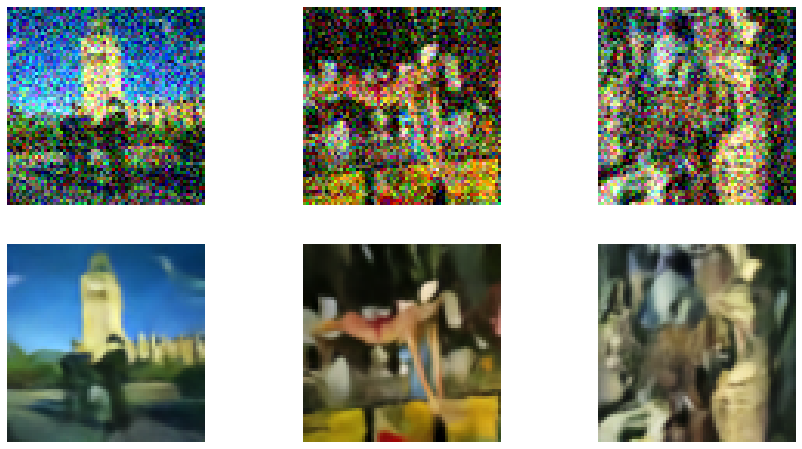

mean MSE=  0.0024135683
mean PSNR=  26.489742


In [154]:
modelis = torch.load('./outputs/best_model_denoiser.pth', map_location=device)
modelis = modelis.to(device)
psnr0 = []
mse0 = []
modelis.eval()
with torch.no_grad():

    for data, _ in test_dataloader:
        images=torch.clone(data)
        images = images.to(device)
        #data = torch.tensor(random_noise(data, mode='salt', amount=0.15))
        data = (data.cpu().detach() + torch.normal(0,0.2,data.shape)).clip(0,1)
        data = data.to(device)
        
        recon = modelis(data)
        
        break

print("Validation set:")
psnr, mse = eval_model(modelis, test_dataloader, noise_type="normal", noise_parameter=0.2)
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()
mse_model_denoiser=mse
print("mean MSE= ", mse)
print("mean PSNR= ", psnr)

Text(0.5, 1.0, 'PSNR accuracy Curves')

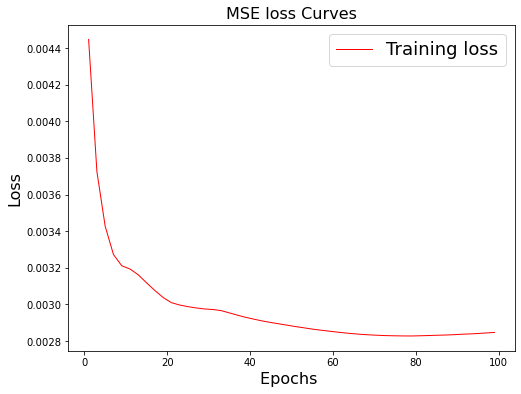

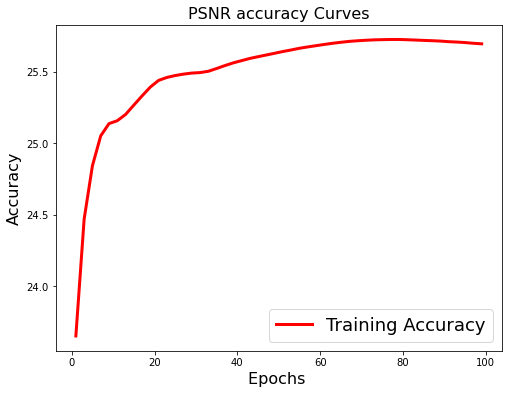

In [152]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, mse_train2,'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('MSE loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, psnr_train2,'r',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('PSNR accuracy Curves',fontsize=16)

In [44]:
## Learning Enriched Features for Fast Image Restoration and Enhancement
## Syed Waqas Zamir, Aditya Arora, Salman Khan, Munawar Hayat, Fahad Shahbaz Khan, Ming-Hsuan Yang, and Ling Shao
## IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)
## https://www.waqaszamir.com/publication/zamir-2022-mirnetv2/

# --- Imports --- #
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pdb import set_trace as stx
import math

##########################################################################
##---------- Selective Kernel Feature Fusion (SKFF) ----------
class SKFF(nn.Module):
    def __init__(self, in_channels, height=3,reduction=8,bias=False):
        super(SKFF, self).__init__()
        
        self.height = height
        d = max(int(in_channels/reduction),4)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(nn.Conv2d(in_channels, d, 1, padding=0, bias=bias), nn.LeakyReLU(0.2))

        self.fcs = nn.ModuleList([])
        for i in range(self.height):
            self.fcs.append(nn.Conv2d(d, in_channels, kernel_size=1, stride=1,bias=bias))
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inp_feats):
        batch_size = inp_feats[0].shape[0]
        n_feats =  inp_feats[0].shape[1]
        

        inp_feats = torch.cat(inp_feats, dim=1)
        inp_feats = inp_feats.view(batch_size, self.height, n_feats, inp_feats.shape[2], inp_feats.shape[3])
        
        feats_U = torch.sum(inp_feats, dim=1)
        feats_S = self.avg_pool(feats_U)
        feats_Z = self.conv_du(feats_S)

        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        attention_vectors = torch.cat(attention_vectors, dim=1)
        attention_vectors = attention_vectors.view(batch_size, self.height, n_feats, 1, 1)
        # stx()
        attention_vectors = self.softmax(attention_vectors)
        
        feats_V = torch.sum(inp_feats*attention_vectors, dim=1)
        
        return feats_V        



class ContextBlock(nn.Module):

    def __init__(self, n_feat, bias=False):
        super(ContextBlock, self).__init__()

        self.conv_mask = nn.Conv2d(n_feat, 1, kernel_size=1, bias=bias)
        self.softmax = nn.Softmax(dim=2)

        self.channel_add_conv = nn.Sequential(
            nn.Conv2d(n_feat, n_feat, kernel_size=1, bias=bias),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_feat, n_feat, kernel_size=1, bias=bias)
        )

    def modeling(self, x):
        batch, channel, height, width = x.size()
        input_x = x
        # [N, C, H * W]
        input_x = input_x.view(batch, channel, height * width)
        # [N, 1, C, H * W]
        input_x = input_x.unsqueeze(1)
        # [N, 1, H, W]
        context_mask = self.conv_mask(x)
        # [N, 1, H * W]
        context_mask = context_mask.view(batch, 1, height * width)
        # [N, 1, H * W]
        context_mask = self.softmax(context_mask)
        # [N, 1, H * W, 1]
        context_mask = context_mask.unsqueeze(3)
        # [N, 1, C, 1]
        context = torch.matmul(input_x, context_mask)
        # [N, C, 1, 1]
        context = context.view(batch, channel, 1, 1)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.modeling(x)

        # [N, C, 1, 1]
        channel_add_term = self.channel_add_conv(context)
        x = x + channel_add_term

        return x

##########################################################################
### --------- Residual Context Block (RCB) ----------
class RCB(nn.Module):
    def __init__(self, n_feat, kernel_size=3, reduction=8, bias=False, groups=1):
        super(RCB, self).__init__()
        
        act = nn.LeakyReLU(0.2)

        self.body = nn.Sequential(
            nn.Conv2d(n_feat, n_feat, kernel_size=3, stride=1, padding=1, bias=bias, groups=groups),
            act, 
            nn.Conv2d(n_feat, n_feat, kernel_size=3, stride=1, padding=1, bias=bias, groups=groups)
        )

        self.act = act
        
        self.gcnet = ContextBlock(n_feat, bias=bias)

    def forward(self, x):
        res = self.body(x)
        res = self.act(self.gcnet(res))
        res += x
        return res


##########################################################################
##---------- Resizing Modules ----------    
class Down(nn.Module):
    def __init__(self, in_channels, chan_factor, bias=False):
        super(Down, self).__init__()

        self.bot = nn.Sequential(
            nn.AvgPool2d(2, ceil_mode=True, count_include_pad=False),
            nn.Conv2d(in_channels, int(in_channels*chan_factor), 1, stride=1, padding=0, bias=bias)
            )

    def forward(self, x):
        return self.bot(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, scale_factor, chan_factor=2, kernel_size=3):
        super(DownSample, self).__init__()
        self.scale_factor = int(np.log2(scale_factor))

        modules_body = []
        for i in range(self.scale_factor):
            modules_body.append(Down(in_channels, chan_factor))
            in_channels = int(in_channels * chan_factor)
        
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        x = self.body(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, chan_factor, bias=False):
        super(Up, self).__init__()

        self.bot = nn.Sequential(
            nn.Conv2d(in_channels, int(in_channels//chan_factor), 1, stride=1, padding=0, bias=bias),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=bias)
            )

    def forward(self, x):
        return self.bot(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, scale_factor, chan_factor=2, kernel_size=3):
        super(UpSample, self).__init__()
        self.scale_factor = int(np.log2(scale_factor))

        modules_body = []
        for i in range(self.scale_factor):
            modules_body.append(Up(in_channels, chan_factor))
            in_channels = int(in_channels // chan_factor)
        
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        x = self.body(x)
        return x


##########################################################################
##---------- Multi-Scale Resiudal Block (MRB) ----------
class MRB(nn.Module):
    def __init__(self, n_feat, height, width, chan_factor, bias,groups):
        super(MRB, self).__init__()

        self.n_feat, self.height, self.width = n_feat, height, width

        self.dau_top = RCB(int(n_feat*chan_factor**0), bias=bias, groups=groups)
        self.dau_mid = RCB(int(n_feat*chan_factor**1), bias=bias, groups=groups)
        self.dau_bot = RCB(int(n_feat*chan_factor**2), bias=bias, groups=groups)

        self.down2 = DownSample(int((chan_factor**0)*n_feat),2,chan_factor)
        self.down4 = nn.Sequential(
            DownSample(int((chan_factor**0)*n_feat),2,chan_factor), 
            DownSample(int((chan_factor**1)*n_feat),2,chan_factor)
        )

        self.up21_1 = UpSample(int((chan_factor**1)*n_feat),2,chan_factor)
        self.up21_2 = UpSample(int((chan_factor**1)*n_feat),2,chan_factor)
        self.up32_1 = UpSample(int((chan_factor**2)*n_feat),2,chan_factor)
        self.up32_2 = UpSample(int((chan_factor**2)*n_feat),2,chan_factor)

        self.conv_out = nn.Conv2d(n_feat, n_feat, kernel_size=1, padding=0, bias=bias)

        # only two inputs for SKFF
        self.skff_top = SKFF(int(n_feat*chan_factor**0), 2)
        self.skff_mid = SKFF(int(n_feat*chan_factor**1), 2)

    def forward(self, x):
        x_top = x.clone()
        x_mid = self.down2(x_top)
        x_bot = self.down4(x_top)

        x_top = self.dau_top(x_top)
        x_mid = self.dau_mid(x_mid)
        x_bot = self.dau_bot(x_bot)

        x_mid = self.skff_mid([x_mid, self.up32_1(x_bot)])
        x_top = self.skff_top([x_top, self.up21_1(x_mid)])

        x_top = self.dau_top(x_top)
        x_mid = self.dau_mid(x_mid)
        x_bot = self.dau_bot(x_bot)

        x_mid = self.skff_mid([x_mid, self.up32_2(x_bot)])
        x_top = self.skff_top([x_top, self.up21_2(x_mid)])

        out = self.conv_out(x_top)
        out = out + x

        return out

##########################################################################
##---------- Recursive Residual Group (RRG) ----------
class RRG(nn.Module):
    def __init__(self, n_feat, n_MRB, height, width, chan_factor, bias=False, groups=1):
        super(RRG, self).__init__()
        modules_body = [MRB(n_feat, height, width, chan_factor, bias, groups) for _ in range(n_MRB)]
        modules_body.append(nn.Conv2d(n_feat, n_feat, kernel_size=3, stride=1, padding=1, bias=bias))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res


##########################################################################
##---------- MIRNet  -----------------------
class MIRNet_v2(nn.Module):
    def __init__(self,
        inp_channels=3,
        out_channels=3,
        n_feat=80,
        chan_factor=1.5,
        n_RRG=4,
        n_MRB=1, #2
        height=3,
        width=2,
        scale=1,
        bias=False,
        task= None
    ):
        super(MIRNet_v2, self).__init__()

        kernel_size=3
        self.task = task

        self.conv_in = nn.Conv2d(inp_channels, n_feat, kernel_size=3, padding=1, bias=bias)

        modules_body = []
        
        modules_body.append(RRG(n_feat, n_MRB, height, width, chan_factor, bias, groups=1))
        modules_body.append(RRG(n_feat, n_MRB, height, width, chan_factor, bias, groups=2))
        modules_body.append(RRG(n_feat, n_MRB, height, width, chan_factor, bias, groups=4))
        modules_body.append(RRG(n_feat, n_MRB, height, width, chan_factor, bias, groups=4))

        self.body = nn.Sequential(*modules_body)
        self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=1, bias=bias)
        

    def forward(self, inp_img):
        shallow_feats = self.conv_in(inp_img)
        deep_feats = self.body(shallow_feats)

        if self.task == 'defocus_deblurring':
            deep_feats += shallow_feats
            out_img = self.conv_out(deep_feats)

        else:
            out_img = self.conv_out(deep_feats)
            out_img += inp_img

        return F.hardsigmoid(out_img)

In [ ]:
%%time
torch.cuda.empty_cache() 
modelis2 = MIRNet_v2().cuda()
modelis2.to(device)
normal_optimizer_mse2 = optim.AdamW(modelis2.parameters(), lr=1e-4, weight_decay=1e-4, eps=1e-8)

save_best_model = SaveBestModel()


epoch_num2, psnr_train2, mse_train2=train_model(modelis2, "normal", 0.20, normal_optimizer_mse2, train_dataloader, val_dataloader, loss_module,  num_epochs=100)

In [ ]:
modelis = torch.load('./outputs/best_model.pth', map_location=device)
torch.save( modelis, 'outputs/best_model_MIRNet.pth')
modelis = modelis.to(device)

print(f"Best model was loaded\n")
import os
os.remove('./outputs/best_model.pth')
print("Old model removed successfully")
modelis = torch.load('./outputs/best_model_MIRNet.pth', map_location=device)

Validation set:
Peak Signal to Noise Ratio:   Mean: 26.52630043029785 || Std: 1.7001588344573975
Mean Squared Error:   Mean: 0.0023860593792051077 || Std: 0.0008440993842668831


<Figure size 1500x1000 with 0 Axes>

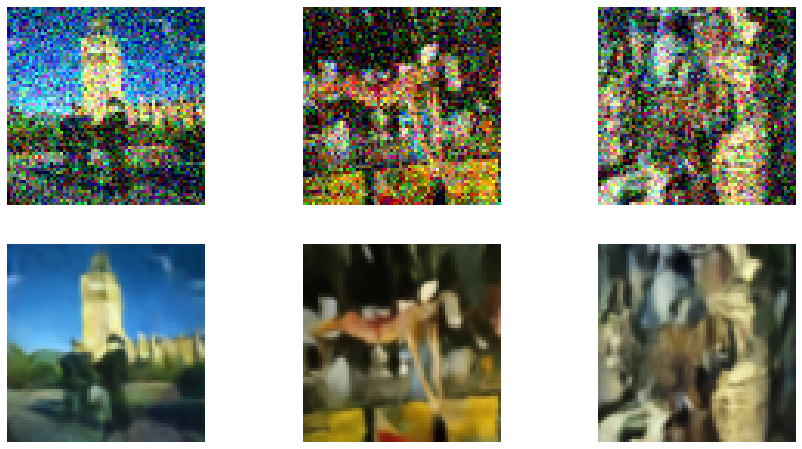

mean MSE=  0.0023860594
mean PSNR=  26.5263


In [45]:
modelis = torch.load('./outputs/best_model_MIRNet.pth', map_location=device)
modelis = modelis.to(device)
psnr0 = []
mse0 = []
modelis.eval()
with torch.no_grad():

    for data, _ in test_dataloader:
        images=torch.clone(data)
        images = images.to(device)
        #data = torch.tensor(random_noise(data, mode='salt', amount=0.15))
        data = (data.cpu().detach() + torch.normal(0,0.2,data.shape)).clip(0,1)
        data = data.to(device)
        
        recon = modelis(data)
        
        break

print("Validation set:")
psnr, mse = eval_model(modelis, test_dataloader, noise_type="normal", noise_parameter=0.2)
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()
mse_model_MIRNet=mse
print("mean MSE= ", mse)
print("mean PSNR= ", psnr)

In [ ]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, mse_train2,'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('MSE loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(epoch_num2, psnr_train2,'r',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('PSNR accuracy Curves',fontsize=16)

In [ ]:
print('mse_model_denoise\t=', mse_model_denoise)
print('mse_model_dnCNN6HL\t=', mse_model_dnCNN6HL)
print('mse_model_UdnCNN4\t=', mse_model_UdnCNN4)
print('mse_model_DuDnCNN4\t=', mse_model_DuDnCNN4)
print('mse_model_UNet\t\t=', mse_model_UNet)
print('mse_model_Efi\t\t=', mse_model_Efi)
print('mse_model_denoiser\t=', mse_model_denoiser)
print('mse_model_MIRNet\t=', mse_model_MIRNet)
print('Min=', min([mse_model_denoise, mse_model_dnCNN6HL, mse_model_UdnCNN4, mse_model_DuDnCNN4,mse_model_UNet, mse_model_Efi, mse_model_denoiser, mse_model_MIRNet]))